<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка выборок</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель_1---LGBMRegressor" data-toc-modified-id="Модель_1---LGBMRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель_1 - LGBMRegressor</a></span></li><li><span><a href="#Модель_2----CatBoostRegressor" data-toc-modified-id="Модель_2----CatBoostRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель_2 -  CatBoostRegressor</a></span></li><li><span><a href="#Модель_3---Линейная-регрессия" data-toc-modified-id="Модель_3---Линейная-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель_3 - Линейная регрессия</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ результатов</a></span></li><li>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

### Знакомство с данными

In [1]:
#импортируем необходимые библиотеки и алгоритмы
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
!pip install catboost
from catboost import CatBoostRegressor
!pip install lightgbm
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#прочтем файл с данными, выведем общую информацию:
data = pd.read_csv('C:/Users/crupi/Downloads/taxi.csv')
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
#перезапишем индексы на даты, поменяем формат, проведем ресемплирование по 1 часу:
data = pd.read_csv('C:/Users/crupi/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

### Анализ данных

In [4]:
#посмотрим, какие значеия содержатся в таблице:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

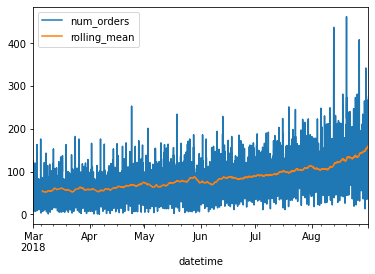

In [5]:
#добавим скользящее среднее за 5 дней, построим график:
data['rolling_mean'] = data.rolling(120).mean()
data.plot()

Благодаря тому, что мы отразили скользящее среднее на графике,  мы можем наблюдать в среднем тенденцию роста числа заказов. 
Посмотрим на тренды и сезонность. 

Text(0.5, 1.0, 'Остаток')

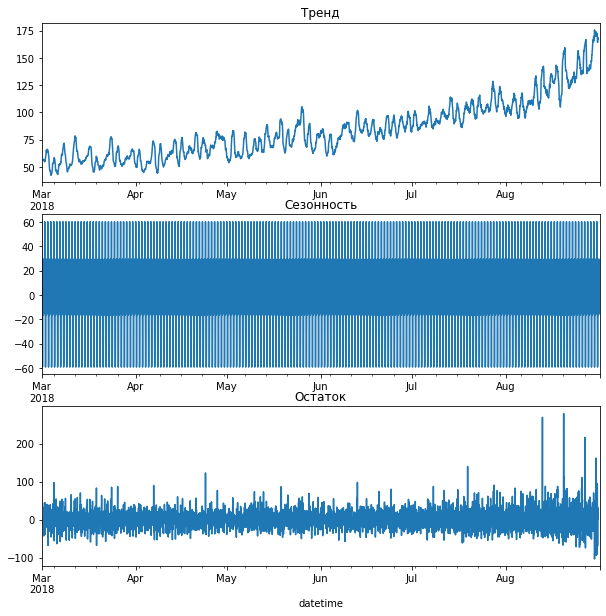

In [6]:
# построим график для тренда, сезонности и остатков:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

Мы еще раз убедились в том, что есть тренд на увеличениезаказов. Посмотрим сезонность в разрезе 1 недели. 

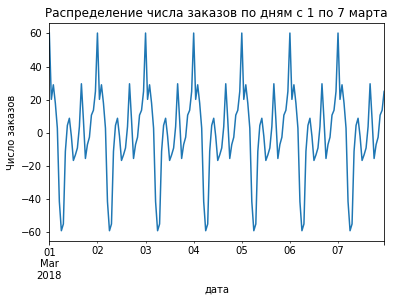

In [7]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()
plt.title('Распределение числа заказов по дням с 1 по 7 марта')
plt.xlabel('дата')
plt.ylabel('Число заказов')
plt.show()

Наблюдается сезонность в разрезе дня: есть как часы пик, так и спады в количестве заказов. 

На этом мы закончим наше общее знакомство с данными. И перейдем к формированию признаков и разделению данных на выборки для дальнейшего обучения моделей. 

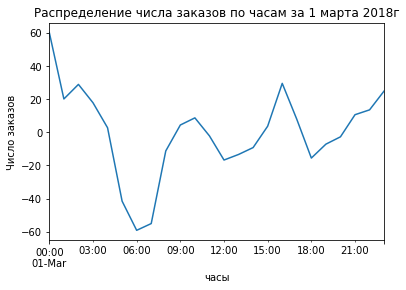

In [8]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot()
plt.title('Распределение числа заказов по часам за 1 марта 2018г')
plt.xlabel('часы')
plt.ylabel('Число заказов')
plt.show()

### Подготовка выборок

In [9]:
#удалим ранее добавленный столбец 'rolling_mean':
data = data.drop(['rolling_mean'], axis=1)

In [10]:
#запишем функцию для добавления новых признаков: 
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(3, max_lag + 1, 3):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 168)

In [11]:
#разделим данные на обучающую и тестовую выборку:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#для проверки выведем на экран размеры получившихся выборок методом shape: 
display('Размер features и target обучающей выборки:', features_train.shape, target_train.shape)
display('Размер features и target тестовой выборки:', features_test.shape, target_test.shape)

'Размер features и target обучающей выборки:'

(3806, 11)

(3806,)

'Размер features и target тестовой выборки:'

(442, 11)

(442,)

In [12]:
#зададим кросс-валидацию TimeSeriesSplit:
timecv = TimeSeriesSplit(n_splits=5)

Выборки готовы. Приступим к обучению моделей. 

## Обучение моделей

В рамках проекта мы обучим 3 модели, из них 2 бустинговые (LGBMRegressor и CatBoostRegressor) и 1 "простая" модель- линейной регрессии (LinearRegression). Подберем гиперпараметры с помощью GridSearchCV. 

Для оценки качества моделей мы будем применять метрику RMSE.  Запишем функцию для вычисления RMSE.

In [13]:
def rmse_calc(target, predict):
    rmse = mean_squared_error(target, predict)**0.5
    return rmse

### Модель_1 - LGBMRegressor

In [14]:
#с помощью модуля GridSearchCV подберем оптимальные гиперпараметры модели:
model_1 = LGBMRegressor(random_state=1000000)
parametrs_1 = {'n_estimators': [10, 50, 100],
              'num_leaves': [5, 10, 50], 
              'learning_rate':[0.01, 0.05, 0.1]}
grid_1 = GridSearchCV(model_1, parametrs_1,cv=timecv, scoring='neg_mean_squared_error')
grid_1.fit(features_train, target_train)
display(grid_1.best_params_)
display(grid_1.best_score_)

{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 10}

-828.4162885696278

In [15]:
#перезапишем модель с оптимальными ГП:
model_1 = LGBMRegressor(random_state=1000000,n_estimators=100, learning_rate=0.05, num_leaves=50)
model_1.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.05, num_leaves=50, random_state=1000000)

In [16]:
#получим предсказания:
predict_1 = model_1.predict(features_test)

In [17]:
#найдем RMSE первой модели:
rmse_1 =  rmse_calc(target_test, predict_1)
display('RMSE модели LGBMRegressor:',rmse_1)

'RMSE модели LGBMRegressor:'

44.74009964771374

### Модель_2 -  CatBoostRegressor

In [18]:
#с помощью модуля GridSearchCV подберем оптимальные гиперпараметры модели:
model_2 = CatBoostRegressor(random_state=1000000)
parametrs_2 = {'iterations': [10, 100], 
              'learning_rate':[0.01, 0.1]}
grid_2 = GridSearchCV(model_2, parametrs_2,cv=timecv, scoring='neg_mean_squared_error')
grid_2.fit(features_train, target_train, verbose=10)
display(grid_2.best_params_)
display( grid_2.best_score_)

0:	learn: 29.4446406	total: 187ms	remaining: 1.68s
9:	learn: 28.3482789	total: 193ms	remaining: 0us
0:	learn: 30.8160055	total: 38.4ms	remaining: 345ms
9:	learn: 29.7454087	total: 45.4ms	remaining: 0us
0:	learn: 32.9369820	total: 1.26ms	remaining: 11.4ms
9:	learn: 31.7828822	total: 9.24ms	remaining: 0us
0:	learn: 33.2420350	total: 1.32ms	remaining: 11.9ms
9:	learn: 32.0861771	total: 10.2ms	remaining: 0us
0:	learn: 34.6323596	total: 7.9ms	remaining: 71.1ms
9:	learn: 33.4286858	total: 17.4ms	remaining: 0us
0:	learn: 28.4270622	total: 15.1ms	remaining: 136ms
9:	learn: 21.6337779	total: 21.9ms	remaining: 0us
0:	learn: 29.8150697	total: 6.52ms	remaining: 58.7ms
9:	learn: 23.4290773	total: 13.5ms	remaining: 0us
0:	learn: 31.8062561	total: 1.16ms	remaining: 10.4ms
9:	learn: 24.8955952	total: 9.08ms	remaining: 0us
0:	learn: 32.1402526	total: 18.1ms	remaining: 163ms
9:	learn: 25.3608338	total: 27.8ms	remaining: 0us
0:	learn: 33.4097140	total: 14.2ms	remaining: 128ms
9:	learn: 26.7076593	total: 

{'iterations': 100, 'learning_rate': 0.1}

-808.5687262350954

In [19]:
#перезапишем модель с оптимальными ГП: 
model_2 = CatBoostRegressor(random_state=1000000, learning_rate=0.1, iterations=100)
model_2.fit(features_train, target_train, verbose=10)

0:	learn: 37.1219098	total: 10.2ms	remaining: 1.01s
10:	learn: 28.9681299	total: 21.2ms	remaining: 172ms
20:	learn: 26.5071393	total: 32.8ms	remaining: 123ms
30:	learn: 25.3910076	total: 44.5ms	remaining: 99.1ms
40:	learn: 24.7884830	total: 55.5ms	remaining: 79.8ms
50:	learn: 24.2266294	total: 66.4ms	remaining: 63.8ms
60:	learn: 23.7009335	total: 77.4ms	remaining: 49.5ms
70:	learn: 23.2712573	total: 88.7ms	remaining: 36.2ms
80:	learn: 22.8067066	total: 99.6ms	remaining: 23.4ms
90:	learn: 22.4157379	total: 111ms	remaining: 11ms
99:	learn: 22.0503213	total: 121ms	remaining: 0us


In [20]:
#получим предсказания:
predict_2 = model_2.predict(features_test)

In [21]:
#найдем RMSE второй модели:
rmse_2 =  rmse_calc(target_test, predict_2)
display('RMSE модели LGBMRegressor:',rmse_2)

'RMSE модели LGBMRegressor:'

46.732483387903926

### Модель_3 - Линейная регрессия

In [22]:
#обучим третью модель:
model_3 = LinearRegression()
model_3.fit(features_train, target_train)

LinearRegression()

In [23]:
#получим предсказания:
predict_3 = model_3.predict(features_test)

In [24]:
#вычислим RMSE третьей модели:
rmse_3 =  rmse_calc(target_test, predict_3)
display('RMSE модели LinearRegression:',rmse_3)

'RMSE модели LinearRegression:'

48.72670824966048

## Анализ результатов

Для анализа моделей выведем в таблице полученные значения RMSE по каждой модели:

In [25]:
results = pd.DataFrame({
    'model':['LGBMRegressor', 'CatBoostRegressor', 'LinearRegression'], 
    'rmse':[rmse_1, rmse_2, rmse_3]})
results

,model,rmse
0,LGBMRegressor,44.740100
1,CatBoostRegressor,46.732483
2,LinearRegression,48.726708


**Вывод**:
    Наилучший результат показала модель LGBMRegressor с гиперпараметрами: learning_rate=0.05, n_estimators=100, num_leaves=50. RMSE модели 44.74. На втором месте  CatBoostRegressor с гиперпараметрами: learning_rate=0.1, iterations=100. RMSE модели 46,73, данный результат удовлетворяет требованиям заказчика (RMSE<48). Поэтому обе эти модели можем рекомендовать заказчику в целях прогнозирования заказов такси на следующий час.
    Модель линейной регресии с результатом  RMSE=48,72 требованиям заказчика не удовлетворяет и не может быть рекомендована. 

Для наглядности выведем на графике предсказания моделей и целевой признак из тестовой выборки. Запишем функцию, чтобы не дулировать код. 

In [26]:
#функция для вывода графиков: 
def comparison_charts (target, predict):
    plt.figure(figsize=(15,7))
    plt.plot(target, label='Целевые значения')
    predict = pd.Series(predict, index=target.index)
    plt.plot(predict, label ='Предсказанные значения')
    plt.title('Предсказания и реальные данные')
    plt.legend(loc='best')
    plt.xlabel('дата')
    plt.ylabel('Число заказов')
    plt.show()

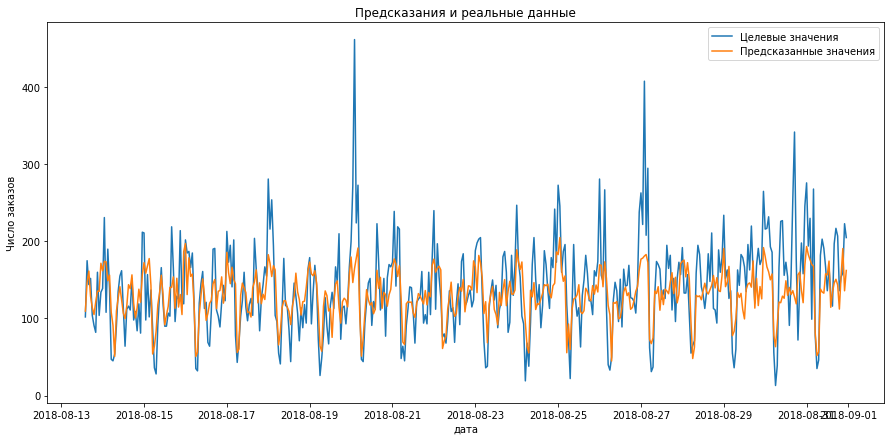

In [27]:
#выведем на экран график предсказания модели LGBMRegressor и целевого признака:
comparison_charts (target_test, predict_1)

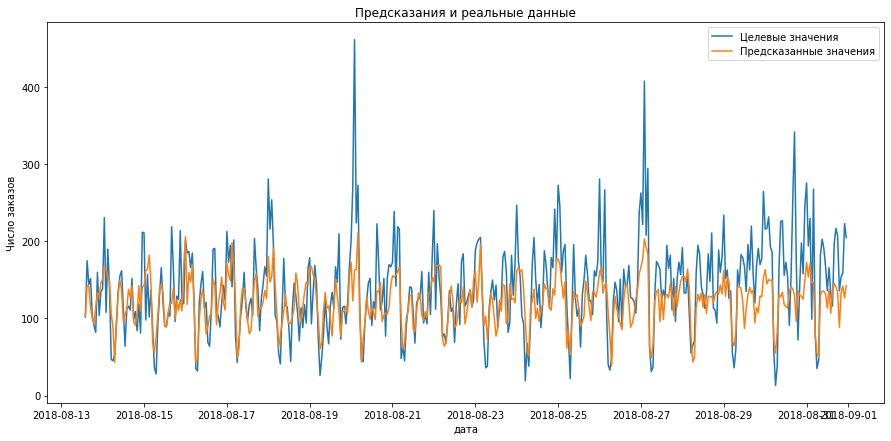

In [28]:
#выведем на экран график предсказания модели CatBoostRegressor и целевого признака:
comparison_charts (target_test, predict_2)

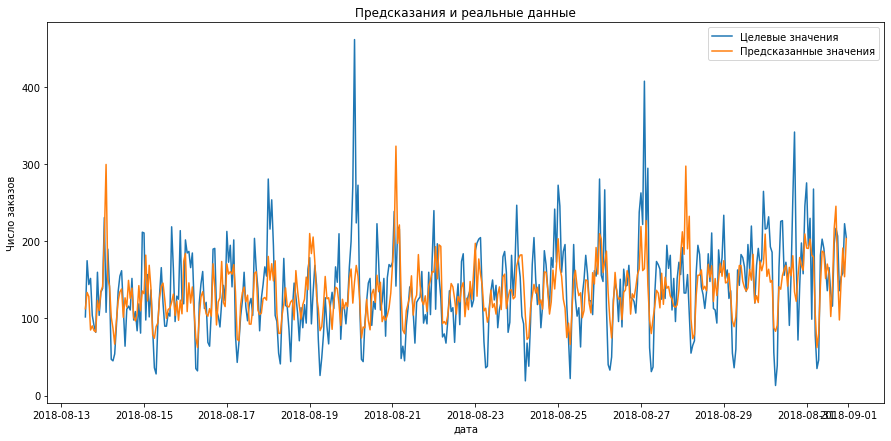

In [29]:
#выведем на экран график предсказания модели LinearRegression  и целевого признака:
comparison_charts (target_test, predict_3)

По графикам видно, что модели плохо предсказывают "выбросы" - всплеск заказов. При этом "типичный" показатель числа заказов бустинговые модели предсказали достаточно хорошо. А вот предсказания модели линейной регресии "выбиваются" из графика. То есть, модель предсказывает всплеск заказов, а его нет, и наоборот. 